In [1]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from scipy import interpolate

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])
    

In [3]:
print(df.shape[0])
print(df['borehole'].nunique())
df.head()

2837
566


,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.15,0,NaN,NaN,TOPSOIL,Organics,0.3,0.0,0.3
1,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,0.3,0.3,1.4
2,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,1.90,1,Nf,No visible ice,SW-SM,Coarse till,0.3,1.4,2.4
3,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,5.40,1,Nf,No visible ice,GW-GM,Coarse till,0.3,2.4,8.4
4,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,0.0,0.0,2.4


In [4]:
# drop borehole mis-located on water
df = df.drop(df[df['latitude'] >= 69.4475].index)

In [5]:
df['visible_ice'].replace(['None'], 'No visible ice', regex=True, inplace=True)

ordered_ice = ['No visible ice', 'Low', "Medium to high", 'High', 'Pure ice']
df['visible_ice'] = pd.Series(pd.Categorical(df['visible_ice'], categories=ordered_ice, ordered=True))

df = df.dropna(subset=['visible_ice'])

df.tail()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval
2814,68.37778,-133.70142,2013-04-27T00:00:00Z,W14103137-S6-BH12,3.75,1,Nbn,No visible ice,NaN,Till,0.1,3.4,4.1
2815,68.37778,-133.70142,2013-04-27T00:00:00Z,W14103137-S6-BH12,5.70,1,Nf/Nbn,No visible ice,NaN,Till,0.1,4.1,7.3
2816,68.37778,-133.70142,2013-04-27T00:00:00Z,W14103137-S6-BH12,8.20,1,Vx,No visible ice,NaN,Till,0.1,7.3,9.1
2817,68.37810,-133.69862,2013-04-27T00:00:00Z,W14103137-S6-BH13,0.05,0,NaN,No visible ice,ORGANICS,Organics,0.1,0.0,0.1
2818,68.37810,-133.69862,2013-04-27T00:00:00Z,W14103137-S6-BH13,0.30,1,Nbn,No visible ice,NaN,Till,0.1,0.1,0.5


In [6]:
# check None values have been replaced
len(df[df['visible_ice'] == 'None'])

0

In [7]:
df['visible_ice_code'] =  df['visible_ice'].cat.codes
print(df['visible_ice'].unique())
print(df['visible_ice_code'].unique())
df['visible_ice']

['Pure ice', 'No visible ice', 'High', 'Medium to high', 'Low']
Categories (5, object): ['No visible ice' < 'Low' < 'Medium to high' < 'High' < 'Pure ice']
[4 0 3 2 1]


1             Pure ice
2       No visible ice
3       No visible ice
4       No visible ice
5       No visible ice
             ...      
2814    No visible ice
2815    No visible ice
2816    No visible ice
2817    No visible ice
2818    No visible ice
Name: visible_ice, Length: 2716, dtype: category
Categories (5, object): ['No visible ice' < 'Low' < 'Medium to high' < 'High' < 'Pure ice']

In [8]:
# n_depth = 11
# depth_grid = np.linspace(0,5, n_depth)
depth_grid = np.arange(0,5,0.5)
n_depth = len(depth_grid)

n_bh = df['borehole'].nunique()
input = np.zeros([n_depth, n_bh])
print("number of boreholes = {}".format(n_bh))

number of boreholes = 561


In [9]:
df[df['borehole'] == '0170-1-10']

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval,visible_ice_code
1,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,0.3,0.3,1.4,4
2,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,1.90,1,Nf,No visible ice,SW-SM,Coarse till,0.3,1.4,2.4,0
3,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,5.40,1,Nf,No visible ice,GW-GM,Coarse till,0.3,2.4,8.4,0


In [10]:
unique_boreholes = df['borehole'].unique()
n_bh = len(unique_boreholes)
max_depths = np.empty(n_bh)

for i, bh in enumerate(unique_boreholes):
    maxd = np.max(df[df['borehole'] == bh]['depth'])
#     if maxd < 5:
#         df = df.drop(df.index[df['borehole'] == bh])
        
    max_depths[i] = maxd

(array([ 21.,  92., 178., 130.,  91.,   8.,  12.,   7.,  11.,  11.]),
 array([ 0.3 ,  2.38,  4.46,  6.54,  8.62, 10.7 , 12.78, 14.86, 16.94,
        19.02, 21.1 ]),
 <BarContainer object of 10 artists>)

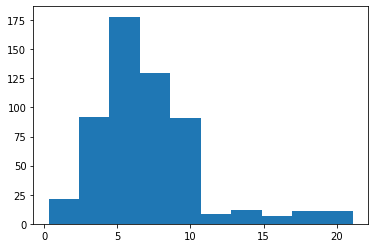

In [11]:
plt.hist(max_depths)

In [12]:
print("number of boreholes = {}".format(df['borehole'].nunique()))

number of boreholes = 561


In [13]:
single_entries = []

In [14]:
for i, bh in enumerate(df.borehole.unique()):
    df_chunk = df[df['borehole'] == bh]
    if df_chunk.shape[0] < 2:
        single_entries.append(i)
    else:
        f = interpolate.interp1d(df_chunk.depth, df_chunk.visible_ice_code, fill_value="extrapolate")
        input[:, i] = f(depth_grid)
    

In [15]:
single_entries

[17, 20, 21, 25, 36, 114, 118, 132, 134, 135, 139, 209, 396, 430, 488]

In [16]:
input = np.delete(input, single_entries, axis=1)

In [17]:
input.shape

(10, 546)

In [18]:
input[input < 0] = 0
input[input > 4] = 4

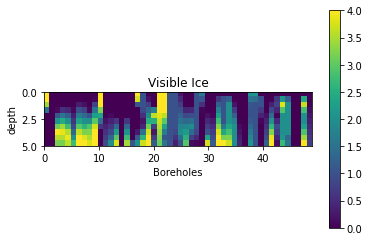

In [19]:
n_max_bh = 50
plt.imshow(input[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
ax = plt.gca()
ax.set_aspect(2)

plt.colorbar()
plt.title("Visible Ice")
plt.xlabel("Boreholes")
plt.ylabel('depth')

plt.show()

In [20]:
n_components = 4

In [21]:
transformer = FastICA(n_components=n_components, random_state=0, max_iter= 200)

In [22]:
sources = transformer.fit_transform(input)

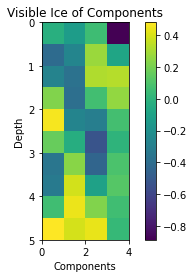

In [23]:
plt.imshow(sources, interpolation = 'none', extent=[0, sources.shape[1], 5, 0])
ax = plt.gca()
ax.set_aspect(2)
plt.colorbar()
plt.title("Visible Ice of Components")
plt.xlabel("Components")
plt.ylabel('Depth')
plt.savefig('components_analysis/components_n{}.png'.format(n_components))
plt.show()

In [24]:
mix = transformer.mixing_
# mix is n_bh x n_components

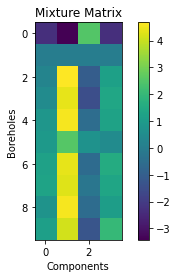

In [25]:
plt.imshow(mix[0:10, :])
plt.colorbar()
plt.title("Mixture Matrix")
plt.xlabel("Components")
plt.ylabel('Boreholes')
plt.savefig('components_analysis/mixture_n{}.png'.format(n_components))
plt.show()

In [26]:
recovered_mixture = transformer.inverse_transform(sources)

In [27]:
recovered_mixture.shape

(10, 546)

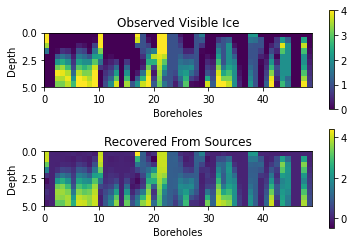

In [28]:
n_max_bh = 50

plt.figure()
plt.subplot(211)
plt.imshow(input[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
ax = plt.gca()
ax.set_aspect(2)

plt.colorbar()
plt.title("Observed Visible Ice")
plt.xlabel("Boreholes")
plt.ylabel('Depth')

plt.subplot(212)
plt.imshow(recovered_mixture[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
ax = plt.gca()
ax.set_aspect(2)
plt.colorbar()
plt.title("Recovered From Sources")
plt.xlabel("Boreholes")
plt.ylabel('Depth')

plt.savefig('components_analysis/comparison_n{}.png'.format(n_components))
plt.show()

In [29]:
diff = input - recovered_mixture

In [30]:
mean_squared_error(input, recovered_mixture)

0.02578718819478075

In [31]:
np.amax(abs(diff))

2.4852127817927485

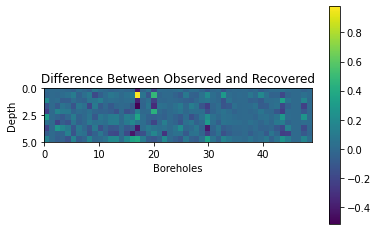

In [32]:
n_max_bh = 50
plt.imshow(diff[:, 0:n_max_bh], interpolation = 'none', extent=[0,n_max_bh-1, 5, 0])
ax = plt.gca()

ax.set_aspect(2)
plt.colorbar()

plt.title("Difference Between Observed and Recovered")
plt.xlabel("Boreholes")
plt.ylabel('Depth')

plt.show()

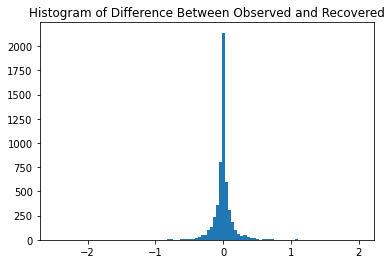

In [33]:
plt.hist(diff.flatten(), bins=100)
plt.title("Histogram of Difference Between Observed and Recovered")

plt.show()

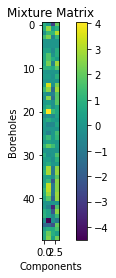

In [34]:
plt.imshow(mix[50:100, :])
plt.colorbar()
plt.title("Mixture Matrix")
plt.xlabel("Components")
plt.ylabel('Boreholes')
plt.show()

In [35]:
dominants = np.argmax(abs(mix), axis = -1)

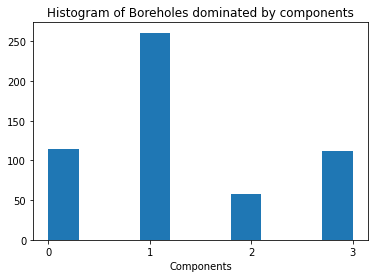

In [36]:
plt.hist(dominants)
plt.xticks(np.unique(dominants))
plt.title('Histogram of Boreholes dominated by components')
plt.xlabel('Components')
plt.savefig('components_analysis/dominants_n{}'.format(n_components))
plt.show()

In [39]:
dominant_strengths = np.amax(abs(mix), axis=-1)

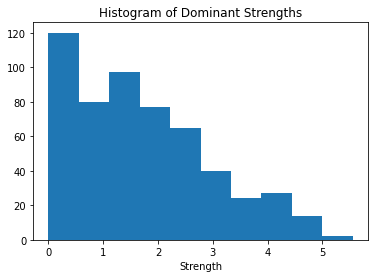

In [43]:
plt.hist(dominant_strengths)
plt.title('Histogram of Dominant Strengths')
plt.xlabel('Strength')
plt.show()

In [ ]:
for i, bh in enumerate(df.borehole.unique()):
    df_chunk = df[df['borehole'] == bh]
    if df_chunk.shape[0] < 2:
        single_entries.append(i)
    else:
        f = interpolate.interp1d(df_chunk.depth, df_chunk.visible_ice_code, fill_value="extrapolate")
        input[:, i] = f(depth_grid)